# HPGe Efficiency with Multiparametric Approach

The following notebbok will guide you in performing efficiency calibration of your HPGe detector. The approach is based on using both the photo-peak efficincy and total efficiency to parametrise the observed counts of each gamma peak. In this way, the summing corrections are already taken care of. The data that are included in the example come from the efficiency calibration of Skowronski et al. (2023) (10.1103/PhysRevC.107.L062801)

The equations for gamma ray are automatically written by specifing for each data which is the excited state that is being populated. Then the code write automatically the equation for each gamma ray by reading the ENSDF data files provided by the NNDC (https://www.nndc.bnl.gov/ensdf/). The ENSDF data are stored in a subdirectory of this notebook thus can be adjusted if needed.

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

# Self made classes
# Data:        take care of reading and storing the data
# Residue:     constract the residuals for each data point
# ResidueNa:   custom version of Residues due to the 22Na particularity
# Efficiency:  just the efficiency functions that are used
from Data import Data
from Residue import Residue
from ResidueNa import ResidueNa
from Efficiency import Efficiency

# We use the lmfit minimizer (https://lmfit.github.io/lmfit-py)
from lmfit import Parameters, Minimizer
from lmfit.printfuncs import report_fit

# Fork of the Nudel package (https://github.com/op3/nudel) 
# to read the ENSDF files (https://www.nndc.bnl.gov/ensdf/)
os.environ['ENSDF_PATH'] = os.getcwd() + "/ensdf/"
from nudel.core import Nuclide

from uncertainties import ufloat

First we define the nuclei that we want to use. Remmeber that we must use the daughter nuclei since these are the one that emits the gamma rays.

In [2]:

nucN  = Nuclide( 15, 8 )     # 14N(p,g)15O
nucAl = Nuclide( 28,  14 )   # 27Al(p,g)28Si
nucCo = Nuclide( 60,  28 )   # 60Co  -> 60Ni
nucCs = Nuclide( 137, 56 )   # 137Cs -> 137Ba
nucBa = Nuclide( 133, 55 )   # 133Ba -> 133Cs
nucNa = Nuclide( 22,  10 )   # 22Na  -> 22Ne
nucY  = Nuclide( 88,  38 )   # 88Y   -> 88Sr

/Users/kuba/Desktop/Didattica/Notebooks/Efficiency/nudel/util.py:531: UserWarning: Quantity ranges not yet supported.
  warnings.warn(f"Quantity ranges not yet supported.")


Now we can add the data files. The data files must have 3 columns as follows:

`Energy (keV)   Yield   Yield Error`

Yield in case of resonances is the number of counts divided by the accumulated charge. For the calibration source, we consider the number of counts divided by the number of source decays without any branching.

In [3]:
dataCo = Data( "data/60co_fels.dat"  ) # 60Co  -> 60Ni
dataCs = Data( "data/137cs_fels.dat" ) # 137Cs -> 137Ba
dataAl = Data( "data/27al_fels.dat"  ) # 27Al(p,g)28Si
dataNa = Data( "data/22na_fels.dat"  ) # 22Na  -> 22Ne

661.66  keV - 1 different paths found for populated state 661.659 with 0.8505+/-0.0029 branching!

661.657 (100.0)	Total Probability: 0.8505+/-0.0029

---------------------------------------------------------------------------------

1173.28  keV - 1 different paths found for populated state 2505.753 with 1.0+/-0 branching!

1173.228 (100.0) -- 1332.501 (100.0)	Total Probability: 0.9999239857786012+/-0

---------------------------------------------------------------------------------

1332.49  keV - 2 different paths found for populated state 2505.753 with 1.0+/-0 branching!

347.14 (0.0076) -- 826.06 (100.0) -- 1332.501 (100.0)	Total Probability: (6.462093785644021+/-0)e-05
1173.228 (100.0) -- 1332.501 (100.0)	Total Probability: 0.9999239857786012+/-0

---------------------------------------------------------------------------------

2505.753  keV - 1 different paths found for populated state 2505.753 with 1.0+/-0 branching!

2505.692 (2e-06)	Total Probability: (1.9998479715572022+/-0

Now we define the Residues objects. The constructor needs the Data object, the Nuclei object and an array of two dimensional arrays that contains the excited level that is being populated (in keV) and its branching. For the latter, we use the uncertainties package (https://pythonhosted.org/uncertainties/) since the Resiudue object already take care of adding the branching uncertainties inside the fit.

In [ ]:
resCs = Residue(   dataCs, nucCs, [ [661.659,  ufloat(0.8505, 0.0029)] ] )
resCo = Residue(   dataCo, nucCo, [ [2505.753, ufloat(1,           0)] ] )
resAl = Residue(   dataAl, nucAl, [ [12541.5,  ufloat(1,           0)] ] )
resNa = ResidueNa( dataNa, nucNa, 1274.537 )
    
residues = [ resCo, resCs, resAl, resNa ]

Here we define some useful functions.

In [4]:
# Function to calculate the efficiency in a given range
def get_eff( params, xmin=0, xmax=12000 ):
    eff_func = Efficiency( params )
    x, eff, eff_tot = [ ], [ ], [ ]
    for i in range( xmin, xmax ):
        x.append( i )
        eff.append( eff_func.effPeak( i/1000 ) )
        eff_tot.append( eff_func.effTot( i/1000 ) )
    return x, eff, eff_tot

# Function to get all the data that can be plotted
def get_data( params ):
    x, disc, data, model, model_no_sum = [ ], [ ], [ ], [ ], [ ]
    for res in residues:
        x            += res.get_energies( )
        disc         += res.get_disc( params )
        data         += res.get_data( )
        model        += res.get_yields( params )
        model_no_sum += res.get_yields_no_sum( params )
    for idx in range( len( disc ) ):
        data[idx]         = [data[idx].nominal_value,data[idx].std_dev]
        disc[idx]         = [disc[idx].nominal_value,disc[idx].std_dev]
        model[idx]        = [model[idx].nominal_value,model[idx].std_dev]
        model_no_sum[idx] = [model_no_sum[idx].nominal_value,model_no_sum[idx].std_dev]
    x            = np.asarray( x )
    disc         = np.asarray( disc )
    data         = np.asarray( data )
    model        = np.asarray( model )
    model_no_sum = np.asarray( model_no_sum )
    return x, disc, data, model, model_no_sum

# Function that calculates the chi2
def chi2( params ):
        chi2 = []
        for res in residues:
            chi2.append( sum( res.get_chi2( params ) ) )
        return chi2

Now we define our parameter. In case of the resonances, please add the parameter that take care of the "rate" of the resonances.

In [5]:
params = Parameters()

#               (NAME    VALUE    VARY   MIN  MAX  EXPR  BRUTE)
params.add_many(('a',       -6,  True,  None,    2, None, None),
                ('b',      0.5,  True,    -2,    2, None, None),
                ('c',     -0.1,  True,    -2,    0, None, None),
                ('k1',    -2.0,  True,    -5,    2, None, None),
                ('k2',    -0.3,  True,    -5,    2, None, None),
                ('k3',    -0.2,  True,    -5,    0, None, None),
                ('R_Al',  7500,  True,  None, None, None, None)
                #('R_N',  7500,  True,  None, None, None, None)
                )

minner = Minimizer( chi2, params )

Now we try to plot the data and the model for our initial parameters.

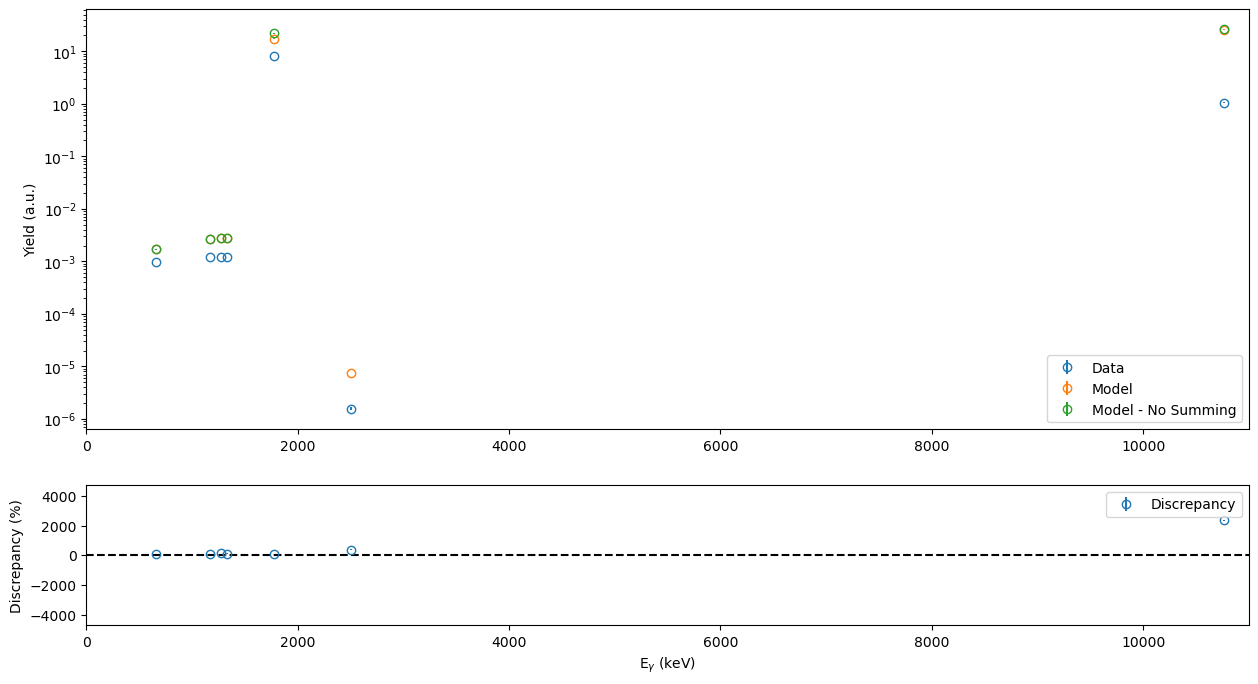

In [7]:
x, disc, data, model, model_no_sum = get_data( params )

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar( x, data[:,0], yerr=data[:,1], label="Data", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model[:,0], yerr=model[:,1], label="Model", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model_no_sum[:,0], yerr=model_no_sum[:,1], label="Model - No Summing", marker='o', linestyle = 'None', markerfacecolor='None' )

ax1.set_yscale( "log" )
ax1.set_xlim( 0, 11000 )
ax1.set_ylabel( "Yield (a.u.)")

ax1.legend( )

ax2.errorbar( x, 100*disc[:,0], yerr=100*disc[:,1], label="Discrepancy", marker='o', linestyle = 'None', markerfacecolor='None' )
ax2.hlines( y=0, xmin=0, xmax=11000, linestyle="--", color="k" )

ax2.legend( )
ax2.set_ylim( [-2*max(abs(100*disc[:,0])),2*max(abs(100*disc[:,0]))] )
ax2.set_xlim( 0, 11000 )
ax2.set_ylabel( "Discrepancy (%)")
ax2.set_xlabel( "E$_{\gamma}$ (keV)")

plt.show( )

Some huge discrepancies are present. Now we can try to fit the data against the model by using the Nelder-Mead method (https://en.wikipedia.org/wiki/Nelder–Mead_method), and then report the fit results.

In [8]:
result = minner.minimize( method='nelder' )
report_fit( result )

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 4638
    # data points      = 4
    # variables        = 7
    chi-square         = 2.28978700
    reduced chi-square = 2.28978700
    Akaike info crit   = 11.7686578
    Bayesian info crit = 7.47271828
##  Warning: uncertainties could not be estimated:
[[Variables]]
    a:    -6.65599047 (init = -6)
    b:     0.15112931 (init = 0.5)
    c:    -0.40920574 (init = -0.1)
    k1:   -3.81241017 (init = -2)
    k2:   -0.59335448 (init = -0.3)
    k3:   -0.15823829 (init = -0.2)
    R_Al:  8235.42516 (init = 7500)


The fit seems to have found a minimum. Let's try to plot it and see the new residuals.

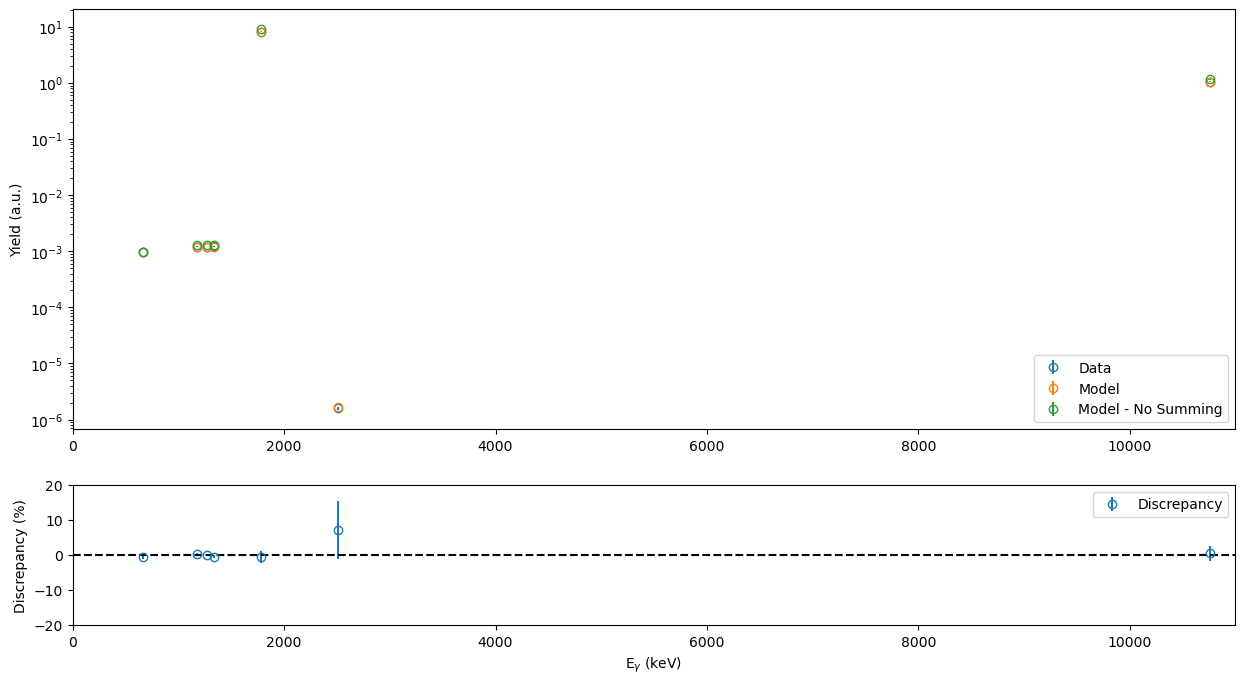

In [10]:
x, disc, data, model, model_no_sum = get_data( result.params )

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

ax1.errorbar( x, data[:,0], yerr=data[:,1], label="Data", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model[:,0], yerr=model[:,1], label="Model", marker='o', linestyle = 'None', markerfacecolor='None' )
ax1.errorbar( x, model_no_sum[:,0], yerr=model_no_sum[:,1], label="Model - No Summing", marker='o', linestyle = 'None', markerfacecolor='None' )

ax1.set_yscale( "log" )
ax1.set_xlim( 0, 11000 )
ax1.set_ylabel( "Yield (a.u.)")

ax1.legend( )

ax2.errorbar( x, 100*disc[:,0], yerr=100*disc[:,1], label="Discrepancy", marker='o', linestyle = 'None', markerfacecolor='None' )
ax2.hlines( y=0, xmin=0, xmax=11000, linestyle="--", color="k" )

ax2.legend( )
ax2.set_ylim( [-20,20] )
ax2.set_xlim( 0, 11000 )
ax2.set_ylabel( "Discrepancy (%)")
ax2.set_xlabel( "E$_{\gamma}$ (keV)")

plt.show( )